# Train the model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import random
import json
import pickle
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model

from matplotlib import pyplot as plt

**Load Data**

In [ ]:
# from tensorflow.keras.optimizer import SGD
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()

intents = json.loads(open('/content/intents2.json').read())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Create bag of words**

In [ ]:
words = []
classes = []
documents = []
ignore_letters=['?','!','.','/','@']

for intent in intents['intents']:
    for pattern in intent['patterns']:
        word_list = nltk.word_tokenize(pattern)
        words.extend(word_list)
        documents.append((word_list,intent['tag']))
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

stop_words = set(stopwords.words('english'))
words = [lemmatizer.lemmatize(word) for word in words if word not in ignore_letters]
words = sorted(set(words))

classes = sorted(set(classes))

pickle.dump(words, open('words.pkl', 'wb'))
pickle.dump(classes, open('classes.pkl', 'wb'))


**Prepare data for training**

In [ ]:
training = []
output_empty = [0] * len(classes)
for document in documents:
    bag=[]
    word_patterns = document[0]
    word_patterns = [lemmatizer.lemmatize(word.lower()) for word in word_patterns]
    for word in words:
        bag.append(1) if word in word_patterns else bag.append(0)

    output_row = list(output_empty)
    output_row[classes.index(document[1])] = 1
    training.append([bag, output_row])

random.shuffle(training)
training = np.array(training, dtype=object)

train_x = list(training[:, 0])
train_y = list(training[:, 1])


**Create model**

In [ ]:
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),),activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))
# gradient_descent_v2.
sgd = SGD(learning_rate=0.01, weight_decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Train model**

Epoch 1/200
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0321 - loss: 4.1702
Epoch 2/200
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0866 - loss: 3.7838
Epoch 3/200
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2044 - loss: 3.2297
Epoch 4/200
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3049 - loss: 2.8031
Epoch 5/200
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3851 - loss: 2.3949
Epoch 6/200
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4618 - loss: 2.0916
Epoch 7/200
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5098 - loss: 1.9303
Epoch 8/200
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5557 - loss: 1.7741
Epoch 9/200
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5762 - loss: 1.5624
Epoch 10/200
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5777 - loss: 1.5235
Epoch 11/200
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6253 - loss: 1.4734
Epoch 12/200
148/148 ━━━━━━━━━━━━━━━━━━━━

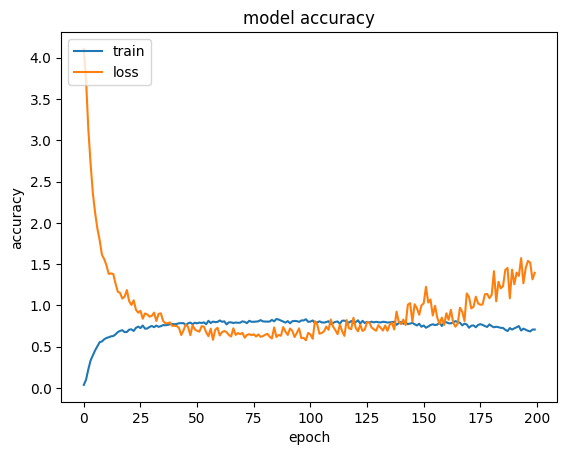

In [ ]:

hist = model.fit(np.array(train_x), np.array(train_y), epochs=200, batch_size=5, verbose=1)

model.save('chatbot_model.keras', hist)
#print('Done')

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'loss'], loc='upper left')
plt.show()

**Save trained model**

In [ ]:
trained_model = load_model("/content/chatbot_model.keras")

#Run the model

**run chatbot**

In [ ]:
lemmatizer = WordNetLemmatizer()
intents = json.loads(open('/content/drive/MyDrive/Colab Notebooks/intents2.json').read())

words = pickle.load(open('words.pkl', 'rb'))
classes = pickle.load(open('classes.pkl', 'rb'))
model = load_model('chatbot_model.keras')

#Clean up the sentences
def clean_up_sentence(sentence):
    sentence_words = nltk.word_tokenize(sentence)
    sentence_words = [lemmatizer.lemmatize(word) for word in sentence_words]
    return sentence_words

#Converts the sentences into a bag of words
def bag_of_words(sentence):
    sentence_words = clean_up_sentence(sentence)
    bag = [0] * len(words)
    for w in sentence_words:
        for i, word in enumerate(words):
            if word == w:
                bag[i] = 1
    return np.array(bag)

def predict_class(sentence):
    bow = bag_of_words(sentence) #bow: Bag Of Words, feed the data into the neural network
    res = model.predict(np.array([bow]))[0] #res: result. [0] as index 0
    ERROR_THRESHOLD = 0.25
    results = [[i,r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]

    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append({'intent': classes[r[0]], 'probability': str(r[1])})
    return return_list


def get_response(intents_list, intents_json):
    tag = intents_list[0]['intent']
    list_of_intents = intents_json['intents']
    result = None # Initialize result to handle cases where no matching tag is found
    for i in list_of_intents:
        if i['tag'] == tag:
            result = random.choice(i['responses'])
            break
    return result # Return the result, which may be None if no matching tag was found

print("Data Science Helper Chatbot is here! Type 'Q' to quit at any time.")

while True:
    message = input("You: ")
    if message.strip().upper() == 'Q':
        print("Goodbye!")
        break

    ints = predict_class(message)

    if not ints:
        print("I'm sorry, I didn't understand that. Could you please rephrase the question?")
    else:
        print(ints)
        res = get_response(ints, intents)
        print(res)

Data Science Helper Chatbot is here! Type 'Q' to quit at any time.
